# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator
from vbranch.utils.generic import get_path, save_results

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'cnn'
DATASET = 'cifar10'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.
TRAIN_FRAC = 1.

BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC, preprocess=True)
# Bagging
if BAGGING_SAMPLES < 1:
    x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                             max_samples=BAGGING_SAMPLES)
    
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
print(X_train.min(), X_train.max())

-1.0 1.0


## Training

In [7]:
def path(n_branches, shared_frac):
    return get_path(DATASET, ARCHITECTURE, 'sensitivity-2', vb=True, 
                    B=n_branches, S=shared_frac)

In [8]:
def build_model(n_branches, shared_frac, name='model'):
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=n_branches, 
                                                                    share_xy=BAGGING_SAMPLES == 0)
#     with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
#         if ARCHITECTURE == 'fcn':
#             layer_spec = [(512, shared_frac), NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2':
#             layer_spec = [(512, shared_frac), 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn3':
#             layer_spec = [(512, shared_frac), 512, 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         elif ARCHITECTURE == 'fcn3A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), 
#                           (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         else:
#             raise ValueError('invalid model')
            
#         model = FCN(inputs, *layer_spec, name=name, shared_frac=1)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'cnn':
            layers = [32, 64]
        elif ARCHITECTURE == 'cnnx':
            layers = [(32, shared_frac), (64, 1.0)]
        else:
            raise ValueError('invalid model')
        model = CNN(inputs, NUM_CLASSES, *layers, name=name, shared_frac=shared_frac)

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                      train_init_op, test_init_op, labels=labels, 
                      callbacks={'acc':classification_acc(n_branches)})

    return model

In [9]:
def train(n_branches, shared_frac, model_id=1):
#     dirpath = path(n_branches, shared_frac)
#     print(dirpath)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()

    if n_branches == 1 or BAGGING_SAMPLES == 0:
        train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    else:
        train_dict = {'x:0': X_train, 'y:0': y_train}
        for i in range(n_branches):
            train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
            train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
        train_dict['batch_size:0'] = BATCH_SIZE

    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

#     model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
#     os.system('mkdir -p ' + model_path)
    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict) #, log_path=model_path)
#     save_results(history, dirpath, 'train_{}.csv'.format(model_id))
    
    return history

In [10]:
# for n_branches in range(2, 7):
#     for shared_frac in [0., 0.25, 0.5, 0.75, 1.]:
#         for t in range(4):
#             train(n_branches, shared_frac, model_id=t+1)
train(n_branches=1, shared_frac=None)

W0801 19:22:50.952553 140212647569152 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:134: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 19:22:50.984726 140212647569152 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:156: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0801 19:22:50.990526 140212647569152 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0801 19:22:50.991183 140212647569152 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

i   Layer name                      Output shape     Parameters        Num param  Inbound            
-----------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                   
-----------------------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,32]  [3,3,3,32] [32]   896        input:0            
-----------------------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,32]  [32] [32]         64         conv2d_1_1         
-----------------------------------------------------------------------------------------------------
2   relu_1_1 (Activation)           [None,32,32,32]                    0          bn_1_1             
----------------------------------------------------------------------------------

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[50000,32,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1_1/Conv2D (defined at /home/gong/research/vbranch/vbranch/layers/convolutional.py:42) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[model/output/output/_103]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[50000,32,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1_1/Conv2D (defined at /home/gong/research/vbranch/vbranch/layers/convolutional.py:42) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node model/conv2d_1_1/Conv2D:
 model/conv2d_1_1/filter/read (defined at /home/gong/research/vbranch/vbranch/layers/convolutional.py:37)	
 input (defined at /home/gong/research/vbranch/vbranch/utils/training.py:158)

Input Source operations connected to node model/conv2d_1_1/Conv2D:
 model/conv2d_1_1/filter/read (defined at /home/gong/research/vbranch/vbranch/layers/convolutional.py:37)	
 input (defined at /home/gong/research/vbranch/vbranch/utils/training.py:158)

Original stack trace for 'model/conv2d_1_1/Conv2D':
  File "/home/gong/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gong/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/gong/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/gong/anaconda3/lib/python3.6/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/gong/anaconda3/lib/python3.6/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/gong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-6b0c690f09f0>", line 5, in <module>
    train(n_branches=1, shared_frac=None)
  File "<ipython-input-9-f47f9a974939>", line 6, in train
    model = build_model(n_branches, shared_frac)
  File "<ipython-input-8-7d88cd29dc0f>", line 30, in build_model
    model = CNN(inputs, NUM_CLASSES, *layers, name=name, shared_frac=shared_frac)
  File "/home/gong/research/vbranch/vbranch/applications/cnn.py", line 66, in CNN
    shared=shared, padding='same', strides=1)
  File "/home/gong/research/vbranch/vbranch/slim.py", line 88, in Conv2D
    return L.Conv2D(filters, kernel_size, name, strides, padding, use_bias)(x)
  File "/home/gong/research/vbranch/vbranch/layers/core.py", line 40, in new_func
    output = func(layer, x)
  File "/home/gong/research/vbranch/vbranch/layers/convolutional.py", line 42, in __call__
    output = tf.nn.conv2d(x, self.f, strides, self.padding.upper())
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1953, in conv2d
    name=name)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


## Evaluation

In [9]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [10]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                    'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [11]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 7):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.50/model_1/ckpt
INFO:tensorflow:Restoring param

INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_3/ckpt
INFO:tensorflow:Rest

In [12]:
with open('results/sensitivity/correlation-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open('results/sensitivity/strength-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(strength_results, f, indent=4)

In [13]:
architecture = ['fcn', 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open('results/sensitivity/correlation-mnist-{}.json'.format(arch), 'r') as f:
        correlation.append(json.load(f))
    with open('results/sensitivity/strength-mnist-{}.json'.format(arch), 'r') as f:
        strength.append(json.load(f))

In [14]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

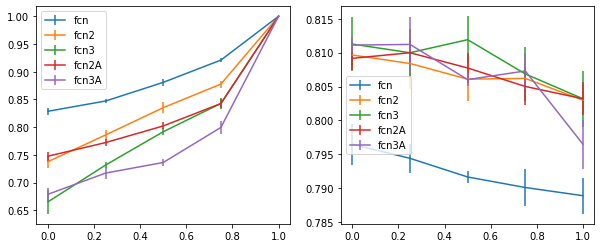

In [15]:
plot_corr_strength(2)

### Model Parameters

In [9]:
# Vbranch params
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
num_branches = 2

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 32,32,3])
    model = build_model(num_branches, frac)
    model.summary()
    vbranch_params.append(model.count_parameters())

W0801 18:55:04.781267 140469450823424 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:130: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 18:55:04.802347 140469450823424 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:152: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0801 18:55:04.810274 140469450823424 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0801 18:55:04.812236 140469450823424 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                                
-------------------------------------------

i   Layer name                      Output shape                     Num param  Inbound            
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,16] [None,32,32,16]  1344       input              
                                    [None,32,32,16] [None,32,32,16]                                
---------------------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,16] [None,32,32,16]  96         conv2d_1_1         


i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,32] []  896        input              
                                    [None,32,32,32] []                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,32] []  64         conv2d_1_1         
                                    [None,32,32,32] []                                
-------------------------------------------

In [10]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

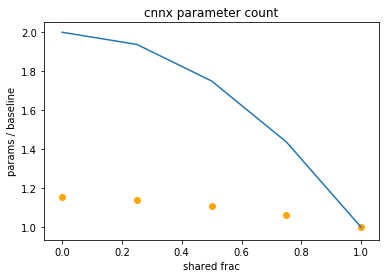

In [11]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()